In [ ]:
import json
from PIL import Image
import requests
from io import BytesIO
import numpy as np

import supervision as sv

import torch
from transformers import AutoModel, AutoProcessor
from sklearn.cluster import AgglomerativeClustering

from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak, Image as RLImage
from reportlab.lib import colors
from reportlab.lib.enums import TA_CENTER
from datetime import datetime

In [7]:
json_data = '''
{
    "content": [
        {
            "type": "text",
            "text": "{'image': {'path': '/tmp/gradio/01b05b775a0c0582972151f2019fb33feb1c1b6987418348a80eb0a043dea945/image.webp', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/01b05b775a0c0582972151f2019fb33feb1c1b6987418348a80eb0a043dea945/image.webp', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'annotations': [{'image': {'path': '/tmp/gradio/b44284812641e0c300b1e14fab850290f00b2eee704eb90d57f339e1a3a3a439/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/b44284812641e0c300b1e14fab850290f00b2eee704eb90d57f339e1a3a3a439/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.62)'}, {'image': {'path': '/tmp/gradio/6aa6706d6a23ad2b5f7e4b1fcda7ddce8a05956fe0cf3f2a7c2124fd141286fa/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/6aa6706d6a23ad2b5f7e4b1fcda7ddce8a05956fe0cf3f2a7c2124fd141286fa/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.65)'}, {'image': {'path': '/tmp/gradio/dec94e4374cfc2b9ca7decb0af7dc5adf41be360caaf7c4bfdd0e6387f6e1cf6/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/dec94e4374cfc2b9ca7decb0af7dc5adf41be360caaf7c4bfdd0e6387f6e1cf6/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.51)'}, {'image': {'path': '/tmp/gradio/0a5e448055112187e0e6c0a2472f9d6b659dbf5126adc823bbf522cb28f1d17d/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/0a5e448055112187e0e6c0a2472f9d6b659dbf5126adc823bbf522cb28f1d17d/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.58)'}, {'image': {'path': '/tmp/gradio/de9fb2b44e3d5da1c9767a24c013623a50f4492a69d0ee03e37a48fb90466b6b/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/de9fb2b44e3d5da1c9767a24c013623a50f4492a69d0ee03e37a48fb90466b6b/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.59)'}, {'image': {'path': '/tmp/gradio/63b5a8b46b5a9ffb6de071789bc4eaf5d5dae0ea44d7355386acc37a5a43c1cf/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/63b5a8b46b5a9ffb6de071789bc4eaf5d5dae0ea44d7355386acc37a5a43c1cf/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.59)'}, {'image': {'path': '/tmp/gradio/94759126f3c4c9f1479f5cce6854dc9e3020990cf695f4993a25f957badcd97a/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/94759126f3c4c9f1479f5cce6854dc9e3020990cf695f4993a25f957badcd97a/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.48)'}, {'image': {'path': '/tmp/gradio/9d9b3c9f1d523663e72744074da0746d92cf7cf4a758b5b5dde7698dd1bc5848/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/9d9b3c9f1d523663e72744074da0746d92cf7cf4a758b5b5dde7698dd1bc5848/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.41)'}, {'image': {'path': '/tmp/gradio/54178ecabc7daceec8098a0bcfc219e1b50a0cbeb80f59181a274c2d23e93dfb/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/54178ecabc7daceec8098a0bcfc219e1b50a0cbeb80f59181a274c2d23e93dfb/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.74)'}, {'image': {'path': '/tmp/gradio/20f06a2207a57d607639f830ec8cd97f502e595769717054c769df036ffc32be/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/20f06a2207a57d607639f830ec8cd97f502e595769717054c769df036ffc32be/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.53)'}, {'image': {'path': '/tmp/gradio/d04e7e5c050321083440f858fa17c9f5d7b5b79083939d27afa18dbb97924de7/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/d04e7e5c050321083440f858fa17c9f5d7b5b79083939d27afa18dbb97924de7/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.75)'}, {'image': {'path': '/tmp/gradio/27a2307119c71d37aa311a7e2a8718bdc29bb410be601f4fee12d28025014bcb/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/27a2307119c71d37aa311a7e2a8718bdc29bb410be601f4fee12d28025014bcb/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.83)'}, {'image': {'path': '/tmp/gradio/a1b50a0fedbf32ec6b288c53db61953de5322851ec6716700d65c6df05d18b4e/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/a1b50a0fedbf32ec6b288c53db61953de5322851ec6716700d65c6df05d18b4e/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.40)'}, {'image': {'path': '/tmp/gradio/01be5edf36ca120378d9743a12aae456c7f4a135ba646d590b466fc692e9936b/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/01be5edf36ca120378d9743a12aae456c7f4a135ba646d590b466fc692e9936b/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.60)'}, {'image': {'path': '/tmp/gradio/b747ffdf9147d93903d2e2a65c512c41cdd5eaf3acf92f3aab4f62a8a668b0f0/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/b747ffdf9147d93903d2e2a65c512c41cdd5eaf3acf92f3aab4f62a8a668b0f0/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.51)'}, {'image': {'path': '/tmp/gradio/9dd2feaeb15605ee0a75a4537abbd3c7b3ea8aba78fc9b5a3d6ab5be3c7f139c/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/9dd2feaeb15605ee0a75a4537abbd3c7b3ea8aba78fc9b5a3d6ab5be3c7f139c/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.77)'}, {'image': {'path': '/tmp/gradio/e8f776d8608f35be37172290f5f195edd92a27d7cba371b1decdc83998e7d061/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/e8f776d8608f35be37172290f5f195edd92a27d7cba371b1decdc83998e7d061/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.62)'}, {'image': {'path': '/tmp/gradio/0791e7ab92add66433fdf65d0ac273897b7f74a1749e8532f8ab9209c3bf9190/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/0791e7ab92add66433fdf65d0ac273897b7f74a1749e8532f8ab9209c3bf9190/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.54)'}, {'image': {'path': '/tmp/gradio/e26331f93b98cf5efc687de5fca3011ed752c96e6bdc96f6305acb2163419ce9/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/e26331f93b98cf5efc687de5fca3011ed752c96e6bdc96f6305acb2163419ce9/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.67)'}, {'image': {'path': '/tmp/gradio/42e19f5e349aaf2467a1004836eae4fdaf3e77f4c0ffba3c238c47d2064b60e0/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/42e19f5e349aaf2467a1004836eae4fdaf3e77f4c0ffba3c238c47d2064b60e0/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.78)'}, {'image': {'path': '/tmp/gradio/37c9da6afa4021e7822dea02914dda6e4e5dd86944efe2ab0b6c5a5e9321f7d2/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/37c9da6afa4021e7822dea02914dda6e4e5dd86944efe2ab0b6c5a5e9321f7d2/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.76)'}, {'image': {'path': '/tmp/gradio/7b6a513190ffa8d65a21039e4aff2ab9363b888341ec06e260634593414a613c/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/7b6a513190ffa8d65a21039e4aff2ab9363b888341ec06e260634593414a613c/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.47)'}, {'image': {'path': '/tmp/gradio/105597d9896bce7363d4608c4ea99a3a8ec1701dfc1ab7555756d75539d6573f/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/105597d9896bce7363d4608c4ea99a3a8ec1701dfc1ab7555756d75539d6573f/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.41)'}, {'image': {'path': '/tmp/gradio/f7d191419ff5c93862b14c1495c7fc9def4cd29b844a0a0ac605e9afb777f3f7/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/f7d191419ff5c93862b14c1495c7fc9def4cd29b844a0a0ac605e9afb777f3f7/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.63)'}, {'image': {'path': '/tmp/gradio/9487735bd264e41bb4be5dd02c462fbf90c5ee056b1ccbb6680778afafe30012/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/9487735bd264e41bb4be5dd02c462fbf90c5ee056b1ccbb6680778afafe30012/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.58)'}, {'image': {'path': '/tmp/gradio/2a9743ec1d0afea41e3401015f40ec107b2f0f5ef7fcae3e5ddfadbf09dda516/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/2a9743ec1d0afea41e3401015f40ec107b2f0f5ef7fcae3e5ddfadbf09dda516/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.56)'}, {'image': {'path': '/tmp/gradio/df7cd2f1dbacf6e39f5a1be5674df119ba099e6290a2d8a18caf3b5a855a4de7/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/df7cd2f1dbacf6e39f5a1be5674df119ba099e6290a2d8a18caf3b5a855a4de7/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.66)'}, {'image': {'path': '/tmp/gradio/6d76638f7b6f912f9114eed8e64aeeb3850e20adf0666189472836340b5dd5d2/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/6d76638f7b6f912f9114eed8e64aeeb3850e20adf0666189472836340b5dd5d2/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.62)'}, {'image': {'path': '/tmp/gradio/977b79cf8f1ee7f5c8b018ec986a513c5b5c62ddd556f39287d461c89e7f4965/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/977b79cf8f1ee7f5c8b018ec986a513c5b5c62ddd556f39287d461c89e7f4965/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.47)'}, {'image': {'path': '/tmp/gradio/fb5693b5ebb6a6945bac1c08ef8c50ef23ea3af55cd8fd3abff96b11e1dc3cd7/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/fb5693b5ebb6a6945bac1c08ef8c50ef23ea3af55cd8fd3abff96b11e1dc3cd7/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.82)'}, {'image': {'path': '/tmp/gradio/2f9d594a99443f2f35077f5e4d77ec9592b95f7f5b7f3555cbfb04bdb8842283/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/2f9d594a99443f2f35077f5e4d77ec9592b95f7f5b7f3555cbfb04bdb8842283/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.77)'}, {'image': {'path': '/tmp/gradio/b1f0e1f75de01a55924938c4fca9db9b8077618d0b1befb0211a80324bcf8be0/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/b1f0e1f75de01a55924938c4fca9db9b8077618d0b1befb0211a80324bcf8be0/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.50)'}, {'image': {'path': '/tmp/gradio/b28cb3615713c91f2501364de1d08f91bf90495bfef95fcae76b9be92905a8f5/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/b28cb3615713c91f2501364de1d08f91bf90495bfef95fcae76b9be92905a8f5/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.54)'}, {'image': {'path': '/tmp/gradio/b880bbd62dc12d201428f8e893a57fbc94bcf81f76841c1b68fcf459263a224a/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/b880bbd62dc12d201428f8e893a57fbc94bcf81f76841c1b68fcf459263a224a/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.79)'}, {'image': {'path': '/tmp/gradio/29e9fb06c3cfac9bdb661ca9822a3addb4c07c25d02f702385e9175379fbfa92/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/29e9fb06c3cfac9bdb661ca9822a3addb4c07c25d02f702385e9175379fbfa92/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.58)'}, {'image': {'path': '/tmp/gradio/aa3e21da0a18786cf43234e67b411291b43b8d2cd35499b8cc69dad1fd2e4eb3/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/aa3e21da0a18786cf43234e67b411291b43b8d2cd35499b8cc69dad1fd2e4eb3/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.74)'}, {'image': {'path': '/tmp/gradio/5a86aa50840a6324747caf31d2f5fa1b4992aa0b56eef5c0d9e2dd959e1df6dd/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/5a86aa50840a6324747caf31d2f5fa1b4992aa0b56eef5c0d9e2dd959e1df6dd/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.62)'}, {'image': {'path': '/tmp/gradio/d91ed7d06c59ae84c95456cebff48a99f8d553aa6ea45dc9ba7882de6c130811/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/d91ed7d06c59ae84c95456cebff48a99f8d553aa6ea45dc9ba7882de6c130811/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.51)'}, {'image': {'path': '/tmp/gradio/1bf364fd8714af5dfb4fe17cdee44dd5a28d8399f54b795a61f952bec5994cb6/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/1bf364fd8714af5dfb4fe17cdee44dd5a28d8399f54b795a61f952bec5994cb6/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.48)'}, {'image': {'path': '/tmp/gradio/7933109a97d08266270eab79ce1e3ea4414ebc21e15166841c36ee4e05207077/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/7933109a97d08266270eab79ce1e3ea4414ebc21e15166841c36ee4e05207077/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.68)'}, {'image': {'path': '/tmp/gradio/5ffa1306b1cb4cab5a2e4376fc7c8b8dd9caf760ecacee44bb01628d69251f86/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/5ffa1306b1cb4cab5a2e4376fc7c8b8dd9caf760ecacee44bb01628d69251f86/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.61)'}, {'image': {'path': '/tmp/gradio/f871bf2175287d12c30a05db3a39cc0617026e026f33f7b53341670f2ff9d177/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/f871bf2175287d12c30a05db3a39cc0617026e026f33f7b53341670f2ff9d177/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.68)'}, {'image': {'path': '/tmp/gradio/e6578b35a99b73c282d3d9ad4d599dbb564bbbad2c4daa249f04b853f15d7872/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/e6578b35a99b73c282d3d9ad4d599dbb564bbbad2c4daa249f04b853f15d7872/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.66)'}, {'image': {'path': '/tmp/gradio/b25aee3eae28e1cae73c710ac91148fa31cb1fe6fe39b8c1a5ea32b6c38fe605/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/b25aee3eae28e1cae73c710ac91148fa31cb1fe6fe39b8c1a5ea32b6c38fe605/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.52)'}, {'image': {'path': '/tmp/gradio/950e8ab8cd434a725069b5d0aa9442a1259133ce4330c93a967deb7dcb30ca84/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/950e8ab8cd434a725069b5d0aa9442a1259133ce4330c93a967deb7dcb30ca84/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.64)'}, {'image': {'path': '/tmp/gradio/9b5f7496877f56498b84d0088d1e89dff1786dc7ba252d2e4df74726e1e0350d/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/9b5f7496877f56498b84d0088d1e89dff1786dc7ba252d2e4df74726e1e0350d/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.47)'}, {'image': {'path': '/tmp/gradio/c90591520110f3ac829caf6673a38f49f299e4b65fe218bf8d1217c56b5e03da/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/c90591520110f3ac829caf6673a38f49f299e4b65fe218bf8d1217c56b5e03da/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.40)'}, {'image': {'path': '/tmp/gradio/85d392c61fa0ae9449282a9d9c76682cd5a9964255112d5920d1ef1144b18583/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/85d392c61fa0ae9449282a9d9c76682cd5a9964255112d5920d1ef1144b18583/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.72)'}, {'image': {'path': '/tmp/gradio/ed477b91948b6398468ba8f23147f183b16624144ee5653cf67ad52a3779b299/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/ed477b91948b6398468ba8f23147f183b16624144ee5653cf67ad52a3779b299/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.57)'}, {'image': {'path': '/tmp/gradio/f0e8997247ef08ba09c07aa0ab719affa99df9020bf50b055334adaa89f67f8c/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/f0e8997247ef08ba09c07aa0ab719affa99df9020bf50b055334adaa89f67f8c/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.56)'}, {'image': {'path': '/tmp/gradio/d3d746f043c856901b82573581887b63ce933584d88cf8c96712d915582a366e/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/d3d746f043c856901b82573581887b63ce933584d88cf8c96712d915582a366e/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.83)'}, {'image': {'path': '/tmp/gradio/d1c9cf65af8ed1d84bbaf1e43af873d2af8ec474da466f26c845ba931d711181/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/d1c9cf65af8ed1d84bbaf1e43af873d2af8ec474da466f26c845ba931d711181/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.75)'}, {'image': {'path': '/tmp/gradio/41f61bce3f7faf961a2f6146aeb91cae47390c6dbb4ae93aa870ab80e4160893/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/41f61bce3f7faf961a2f6146aeb91cae47390c6dbb4ae93aa870ab80e4160893/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.40)'}, {'image': {'path': '/tmp/gradio/a8d4064e28bf429edc4dbec3b93130d099f7b07dd6714c16d20480c05ac3d815/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/a8d4064e28bf429edc4dbec3b93130d099f7b07dd6714c16d20480c05ac3d815/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.70)'}, {'image': {'path': '/tmp/gradio/e038c90fa1fe28ac41895820f4ded53713986bfc1a133a2553133d1543b5f813/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/e038c90fa1fe28ac41895820f4ded53713986bfc1a133a2553133d1543b5f813/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.71)'}, {'image': {'path': '/tmp/gradio/683db483567cb1c2829165aeed192fc92ac1013e35a86e40e0d3258d8bd7834d/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/683db483567cb1c2829165aeed192fc92ac1013e35a86e40e0d3258d8bd7834d/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.77)'}, {'image': {'path': '/tmp/gradio/90066ed3f056bca855c6160da6cd3265a4af2125b8ad7c6a4a437d23d2c460d8/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/90066ed3f056bca855c6160da6cd3265a4af2125b8ad7c6a4a437d23d2c460d8/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.56)'}, {'image': {'path': '/tmp/gradio/fae774387385704972f1da90079dd0de557704e4e13f872f0dddd4908cec7b8f/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/fae774387385704972f1da90079dd0de557704e4e13f872f0dddd4908cec7b8f/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.44)'}, {'image': {'path': '/tmp/gradio/8a978319067f2bfa1071b37aa791ea6ca3128581eca36008c9946e6bfa39d999/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/8a978319067f2bfa1071b37aa791ea6ca3128581eca36008c9946e6bfa39d999/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.57)'}, {'image': {'path': '/tmp/gradio/2bbec69ebbc1c67755429bf77886f1933bbab773b8cd5be779c29c3d870fa64c/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/2bbec69ebbc1c67755429bf77886f1933bbab773b8cd5be779c29c3d870fa64c/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.45)'}, {'image': {'path': '/tmp/gradio/9938367156e5ca293c0fab0abd09363ade637735d7af5948768a53e496c0d67d/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/9938367156e5ca293c0fab0abd09363ade637735d7af5948768a53e496c0d67d/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.45)'}, {'image': {'path': '/tmp/gradio/82d80fd11e1001e82bb6c4075bc31dd19cde280b3ebbcf474d07d62c52b112f1/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/82d80fd11e1001e82bb6c4075bc31dd19cde280b3ebbcf474d07d62c52b112f1/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.62)'}]}"
        }
    ],
    "isError": false
}
'''

data = json.loads(json_data)

In [46]:
with open('Senza nome.json', 'r') as file:
    data = json.load(file)

print(json.dumps(data, indent=4))

{
    "content": [
        {
            "type": "text",
            "text": "{'image': {'path': '/tmp/gradio/cb05d434fd2fc1f21bd3472fc572526896456f4a44d7cd7406ea10c796ad5a87/image.webp', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/cb05d434fd2fc1f21bd3472fc572526896456f4a44d7cd7406ea10c796ad5a87/image.webp', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'annotations': [{'image': {'path': '/tmp/gradio/ee04451dc3458528ea8b5a3f6f0cae68d65c776bbba4a02796eba278d57d73b4/image.png', 'url': 'https://lauz.lab.students.cs.unibo.it/gradio_api/file=/tmp/gradio/ee04451dc3458528ea8b5a3f6f0cae68d65c776bbba4a02796eba278d57d73b4/image.png', 'size': None, 'orig_name': None, 'mime_type': None, 'is_stream': False, 'meta': {'_type': 'gradio.FileData'}}, 'label': 'tree (0.32)'}, {'image': {'path': '/tmp/gradio/13aacd6916a224d7803e89cad4aa8c43acf79539505525325fccde0de9d3646d/image.png', 'url': 'https://lauz.lab.stu

In [ ]:
def extract_crop(original_path, mask_path):
    """
    Extract pixels from original image where mask has red pixels, then crop to mask bounds.
    
    Parameters:
    -----------
    original_path : str
        Path to the original image
    mask_path : str
        Path to the mask image (with red pixels marking regions to extract)
    """
    # Load images
    original = original_path.convert('RGB')
    mask = mask_path.convert('RGB')
    
    # Ensure both images have the same size
    if original.size != mask.size:
        raise ValueError(f"Image sizes don't match: original {original.size}, mask {mask.size}")
    
    # Convert to numpy arrays
    original_array = np.array(original)
    mask_array = np.array(mask)
    
    # Create binary mask where red pixels are (R > threshold and R > G and R > B)
    red_mask = mask_array[:, :, 0] >= 255
    
    # Find bounding box of the red mask
    rows = np.any(red_mask, axis=1)
    cols = np.any(red_mask, axis=0)
    
    if not rows.any() or not cols.any():
        raise ValueError("No red pixels found in mask")
    
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    
    # Create output image with transparent background
    output_array = np.zeros_like(original_array)
    output_array = np.dstack([output_array, np.zeros(original_array.shape[:2], dtype=np.uint8)])  # Add alpha channel
    
    # Copy pixels where mask is red
    output_array[red_mask, :3] = original_array[red_mask]
    output_array[red_mask, 3] = 255  # Set alpha to opaque
    
    # Crop to bounding box
    cropped = output_array[y_min:y_max+1, x_min:x_max+1]
    
    # Convert to PIL Image and save
    output_image = Image.fromarray(cropped, 'RGBA')
    
    return output_image

In [47]:
# accesso a dati
image = data['content'][0]['text']
image_infos = eval(image)

# url originale immagine
original_url = image_infos['image']['url']

# url originale immagine
mask = image_infos['annotations'][0]['image']['url']


original_url = image_infos['image']['url']
original_img = Image.open(BytesIO(requests.get(original_url).content))
objects = []

for annotation in image_infos['annotations']:
    annotation_url = annotation['image']['url']
    annotation_img = Image.open(BytesIO(requests.get(annotation_url).content))
    objects.append(annotation_img)

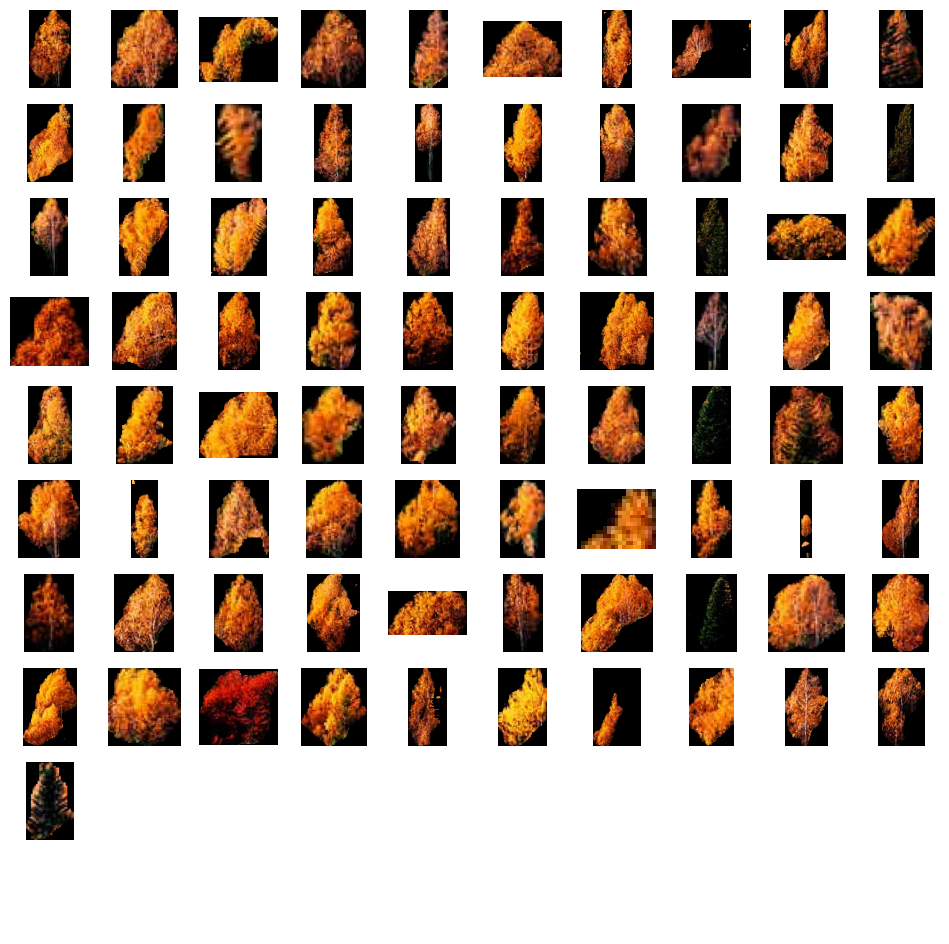

In [ ]:
crops = []
for obj in objects:
    crops.append(extract_crop(original_img, obj))

sv.plot_images_grid(
    images=crops,
    grid_size=(10, 10),
    size=(12, 12)
)

In [52]:
# Load SigLIP-2
model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384").vision_model
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")
model.eval()

# Get embeddings
with torch.no_grad():
    inputs = processor(images=crops, return_tensors="pt")
    embeddings = model(**inputs).pooler_output.cpu().numpy()

# Cluster
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=20)  # or use distance_threshold
labels = clustering.fit_predict(embeddings)

print(labels)  # cluster assignment for each crop

[3 1 0 1 0 1 0 0 1 0 0 0 0 0 4 1 3 0 3 2 4 3 3 3 0 0 3 2 1 1 1 1 1 1 3 3 1
 0 3 1 1 3 1 1 3 0 3 2 0 3 4 0 0 1 1 0 0 0 0 4 0 1 3 1 1 0 1 2 1 3 3 1 1 3
 0 3 0 3 4 1 2]


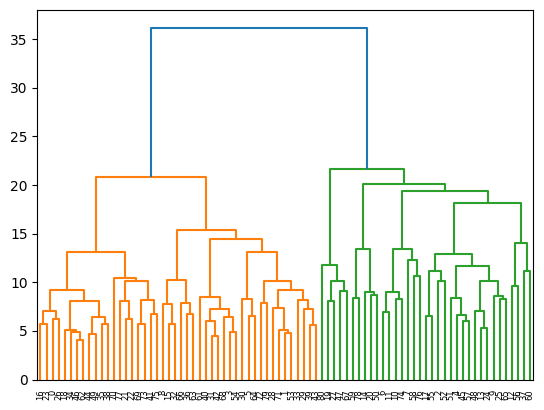

In [53]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linkage_matrix = linkage(embeddings, method='ward')
dendrogram(linkage_matrix)
plt.show()

In [54]:
ids = set(labels)
ids

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}

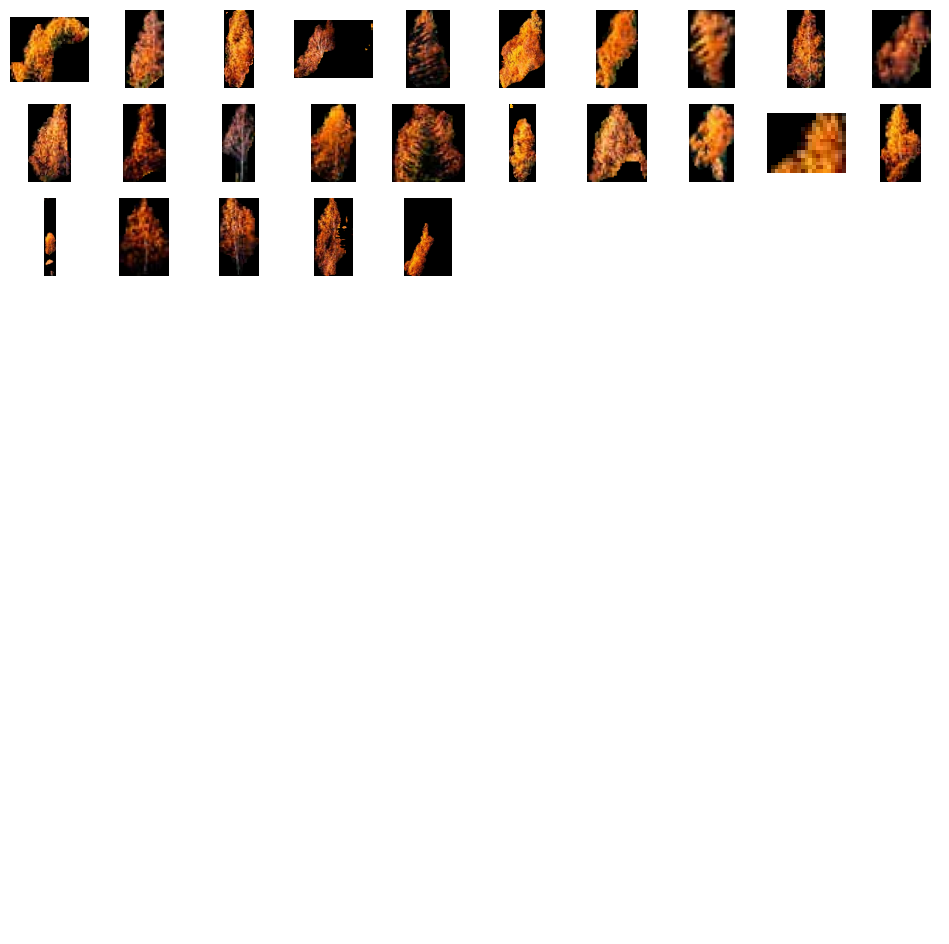

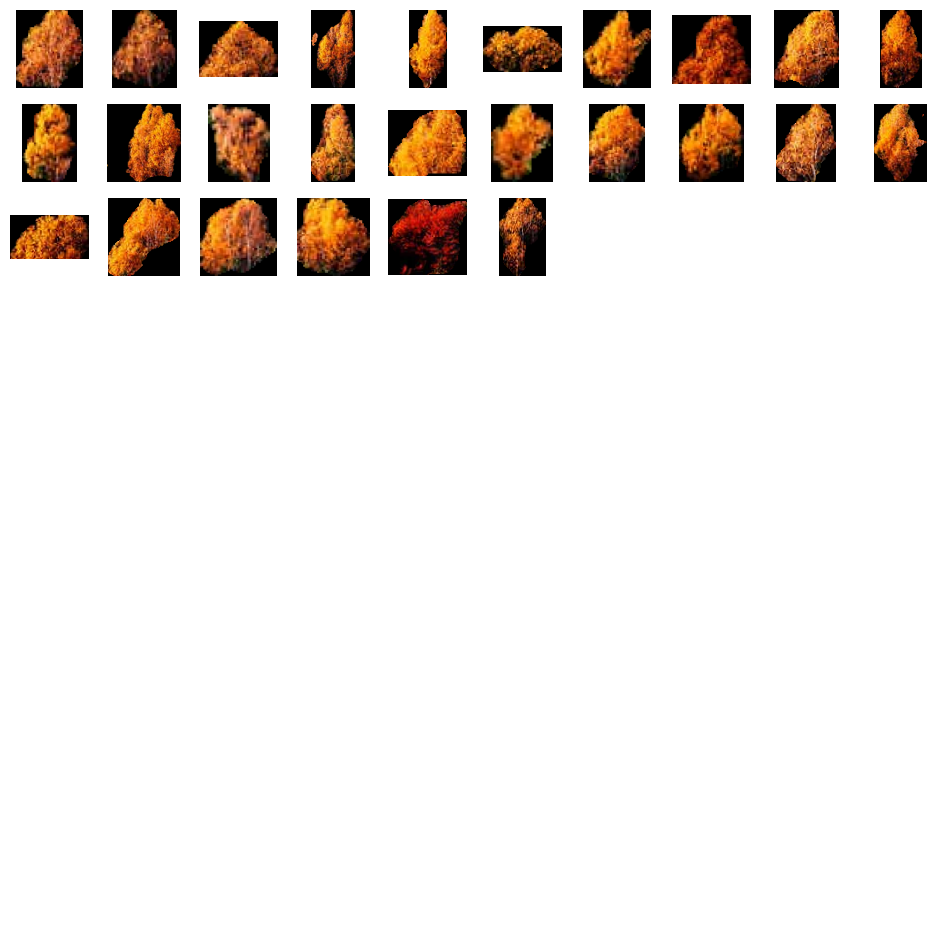

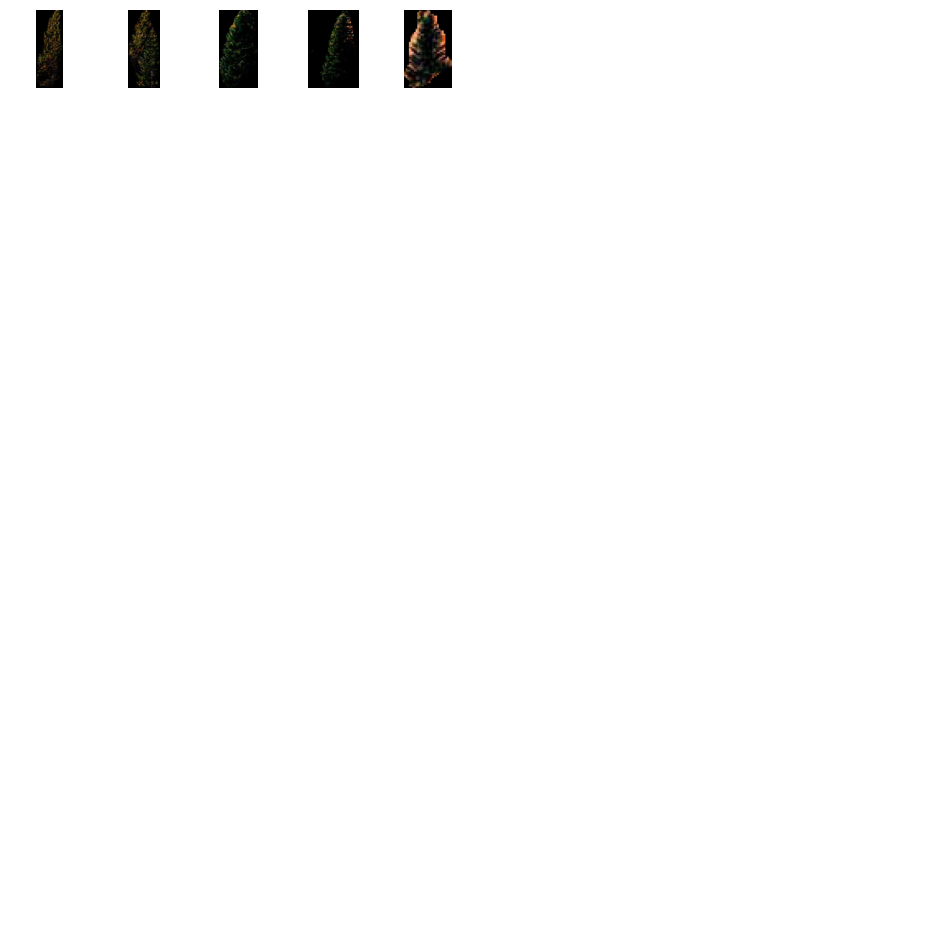

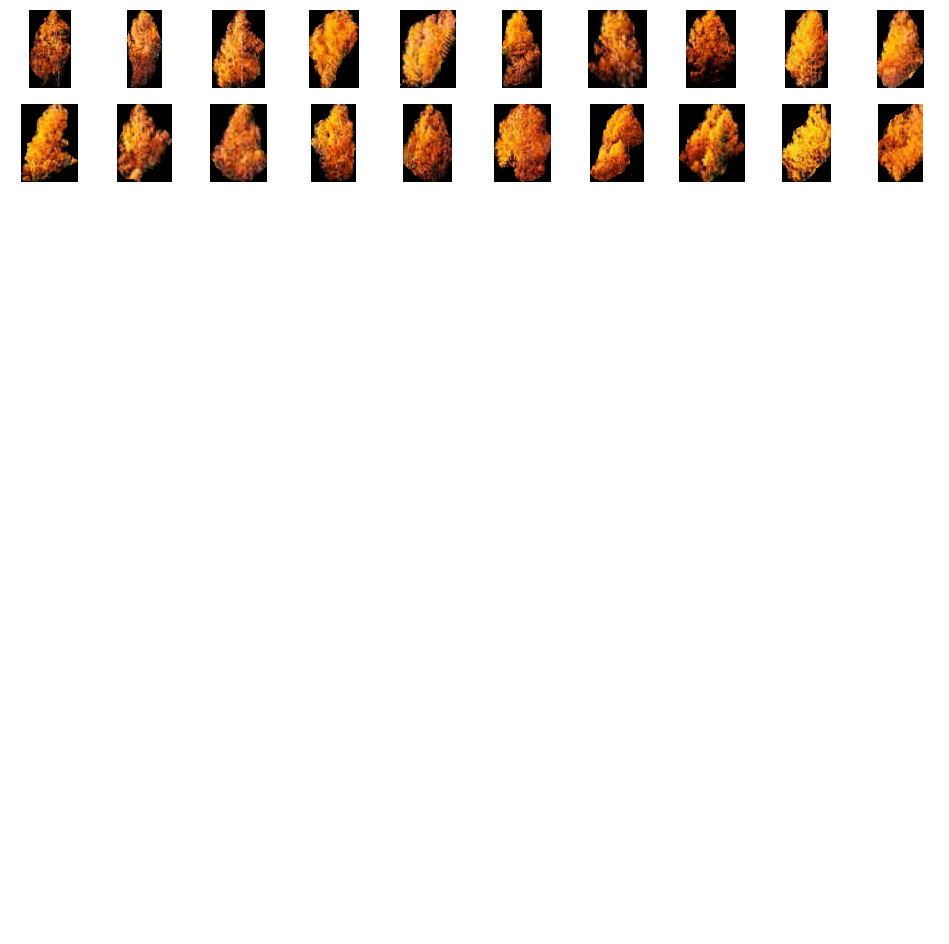

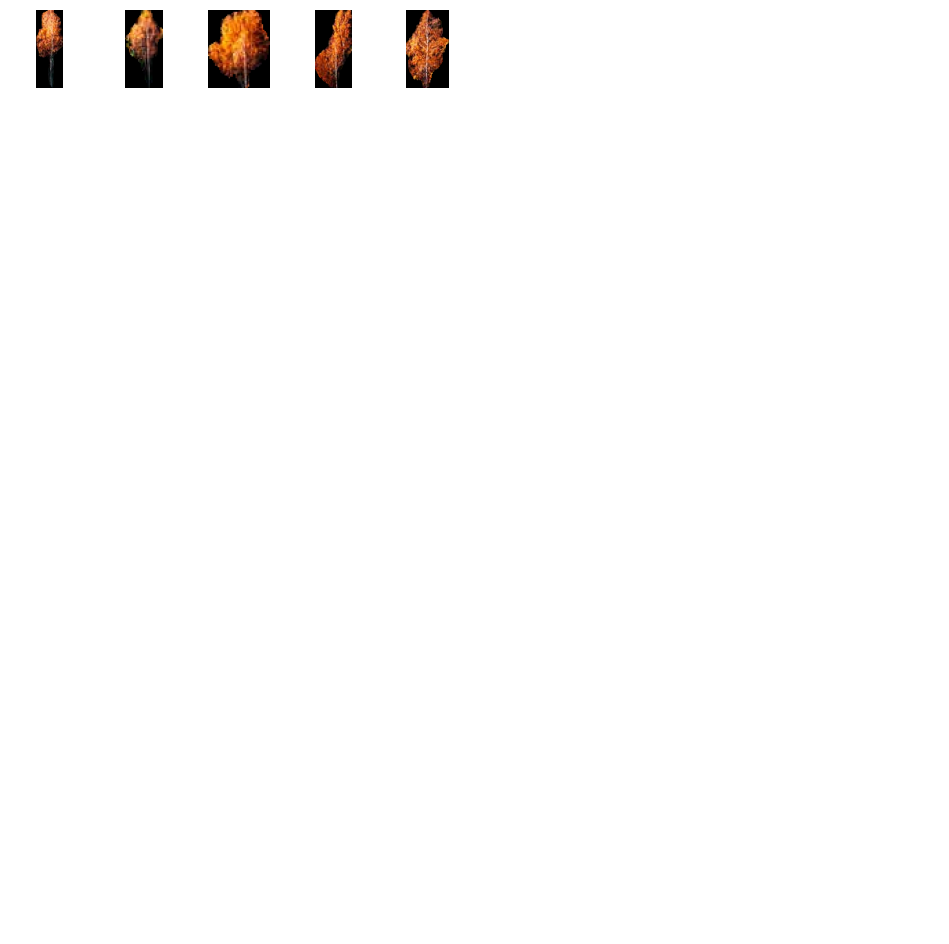

In [60]:
clusters = {}

for id in ids:
    clusters[id] = []

for i, label in enumerate(labels):
    # print(i, label)
    clusters[label].append(crops[i])

for id in ids:
    sv.plot_images_grid(
        images=clusters[id],
        grid_size=(10, 10),
        size=(12, 12)
    )


In [ ]:
def create_pdf_report(clusters, analysis_text, n_clusters, original_url):
    """Crea il PDF del report"""
    
    filename = f"clustering_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf"
    doc = SimpleDocTemplate(filename, pagesize=A4)
    story = []
    
    # Stili
    styles = getSampleStyleSheet()
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Heading1'],
        fontSize=24,
        textColor=colors.HexColor('#2C3E50'),
        spaceAfter=30,
        alignment=TA_CENTER
    )
    
    heading_style = ParagraphStyle(
        'CustomHeading',
        parent=styles['Heading2'],
        fontSize=16,
        textColor=colors.HexColor('#34495E'),
        spaceAfter=12
    )
    
    # Titolo
    story.append(Paragraph("Drone Survey - Clustering Analysis Report", title_style))
    story.append(Spacer(1, 0.3*inch))
    
    # Sommario
    story.append(Paragraph(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", styles['Normal']))
    story.append(Paragraph(f"Total Clusters Identified: {n_clusters}", styles['Normal']))
    story.append(Paragraph(f"Total Objects Analyzed: {len([item for items in clusters.values() for item in items])}", styles['Normal']))
    story.append(Spacer(1, 0.3*inch))
    
    # Analisi di ChatGPT
    story.append(Paragraph("AI Analysis", heading_style))
    for line in analysis_text.split('\n'):
        if line.strip():
            story.append(Paragraph(line, styles['Normal']))
            story.append(Spacer(1, 0.1*inch))
    
    story.append(PageBreak())
    
    # Dettagli dei cluster con immagini
    story.append(Paragraph("Cluster Details", heading_style))
    
    for cluster_id, items in sorted(clusters.items()):
        story.append(Paragraph(f"Cluster {cluster_id} - {len(items)} objects", styles['Heading3']))
        story.append(Spacer(1, 0.2*inch))
        
        # Aggiungi fino a 6 immagini per cluster
        images_to_show = items[:6]
        for item in images_to_show:
            img_buffer = BytesIO()
            item.save(img_buffer, format='PNG')
            img_buffer.seek(0)
            
            # Ridimensiona per il PDF
            img = RLImage(img_buffer, width=2*inch, height=2*inch)
            story.append(img)
            story.append(Spacer(1, 0.1*inch))
        
        if len(items) > 6:
            story.append(Paragraph(f"... and {len(items) - 6} more objects", styles['Italic']))
        
        story.append(Spacer(1, 0.3*inch))
    
    # Build PDF
    doc.build(story)
    print(f"PDF salvato: {filename}")
    return filename